# **1. Matériel : vérifier que le GPU est bien sélectionné (A COMPLETER)**

In [1]:
!nvidia-smi

Tue Mar  4 11:42:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **2. Installation de pytorch lightning**

In [2]:
!pip install pytorch_lightning torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 58.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [3]:
import wandb
wandb.login(key="2bf25da4e2f4523f4be234c0883543eb73000fc3")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: otmane42 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# **3. Importation des librairies**

In [4]:
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST
from torchmetrics.classification import MulticlassConfusionMatrix
from torchmetrics.functional.classification import multiclass_accuracy

from pytorch_lightning.loggers import CSVLogger
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import TensorBoardLogger , WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torchinfo import summary
from lightning_fabric.utilities.seed import seed_everything
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import numpy as np
seed_everything(42,workers=True)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [5]:
NUM_CLASSES = 10
BATCH_SIZE=64 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
EPOCHS=20 #@param [1,5, 10,20,50,100,200] {type:"raw"}
DATA_DIR="."
LOG_DIR="logs/"
ACCELERATOR= "auto" #@param ["cpu","gpu","auto"]

#**4. Téléchargement de la base de données MNIST**

In [6]:
transform = transforms.Compose([transforms.ToTensor()])

# Init DataLoader from MNIST Dataset
train_ds = MNIST(DATA_DIR, train=True, download=True, transform=transform)
test_ds = MNIST(DATA_DIR, train=False, download=True, transform=transform)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.55MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:06<00:00, 244kB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.84MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [7]:
len(train_ds.targets) , len(train_ds)

(60000, 60000)

# Validation/train/test split

In [8]:
targets = train_ds.targets

train_idx, valid_idx= train_test_split(np.arange(len(targets)), test_size=0.2, random_state=42, shuffle=True, stratify=targets)
train_ds_subset = Subset(train_ds, train_idx)
val_ds = Subset(train_ds, valid_idx)

# create train , test and val loaders
train_loader = DataLoader(train_ds_subset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)


In [9]:
targets = train_ds.targets
train_idx, valid_idx= train_test_split(np.arange(len(targets)), test_size=0.2, random_state=42, shuffle=True, stratify=targets)
train_ds_subset = Subset(train_ds, train_idx)
val_ds = Subset(train_ds, valid_idx)
# create train , test and val loaders
train_loader = DataLoader(train_ds_subset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

#**6. Créer la classe MNISTModel du module pytorch lightning (A COMPLETER)**

In [ ]:
class MNISTModel(pl.LightningModule):
    def __init__(self, model, optimizer, num_classes=NUM_CLASSES,lr=1e-4):
        super(MNISTModel, self).__init__()
        self.model = model
        self.num_classes = num_classes
        self.optimizer = optimizer
        self.lr = lr
        # Initialize confusion matrix metric
        self.confusion_matrix = MulticlassConfusionMatrix(num_classes=self.num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        # Apply softmax before computing accuracy
        y_hat_softmax = F.softmax(y_hat, dim=1)
        acc = multiclass_accuracy(
            preds=y_hat_softmax,
            target=y,
            num_classes=self.num_classes)

        # Log training loss
        self.log_dict({'train_loss': loss, "train_acc": acc}, on_step=False, prog_bar=True, logger=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y)

        # Apply softmax before computing accuracy
        y_hat_softmax = F.softmax(y_hat, dim=1)
        val_acc = multiclass_accuracy(
            preds=y_hat_softmax,
            target=y,
            num_classes=self.num_classes)

        self.log_dict({'val_loss': val_loss, "val_acc": val_acc}, prog_bar=True, on_step=False, on_epoch=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        test_loss = F.cross_entropy(y_hat, y)

        # Apply softmax before computing accuracy
        y_hat_softmax = F.softmax(y_hat, dim=1)
        test_acc = multiclass_accuracy(
            preds=y_hat_softmax,
            target=y,
            num_classes=self.num_classes)

        self.log_dict({'test_loss': test_loss, "test_acc": test_acc}, prog_bar=True, on_step=False, on_epoch=True)
        self.confusion_matrix.update(y_hat.argmax(dim=1), y)
        return test_loss
    def on_test_end(self):
        # Compute confusion matrix at the end of the test epoch
        fig_, ax_ = self.confusion_matrix.plot()
        plt.show() # Add this to display the plot
        # Reset the confusion matrix
        self.confusion_matrix.reset()

    def configure_optimizers(self):
        return self.optimizer(self.model.parameters(), lr=self.lr,weight_decay=1e-4)


# Partie 4 : optuna [Facultatif]

## Instalation d'optuna

In [ ]:
!pip install optuna optuna-integration[pytorch_lightning]

## Optimisation des hyperparamètres

In [ ]:
import optuna

class FiveLayerModel(nn.Module):
    def __init__(self, hidden_dim=512, dropout_rate=0.2, activation_name='relu'):
        super(FiveLayerModel, self).__init__()

        self.fc1 = nn.Linear(28*28, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, hidden_dim//4)
        self.fc4 = nn.Linear(hidden_dim//4, hidden_dim//8)
        self.fc5 = nn.Linear(hidden_dim//8, 10)

        self.dropout = nn.Dropout(dropout_rate)

        # Choix de fonction d'activation
        if activation_name == 'relu':
            self.activation = F.relu
        elif activation_name == 'leaky_relu':
            self.activation = F.leaky_relu
        elif activation_name == 'sigmoid':
            self.activation = torch.sigmoid

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dropout(self.activation(self.fc1(x)))
        x = self.dropout(self.activation(self.fc2(x)))
        x = self.dropout(self.activation(self.fc3(x)))
        x = self.dropout(self.activation(self.fc4(x)))
        x = self.fc5(x)
        return x

def objective(trial):
    # Hyperparamètres à optimiser
    hidden_dim = trial.suggest_int("hidden_dim", 128, 512)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    activation_name = trial.suggest_categorical("activation_name", ["relu", "leaky_relu", "sigmoid"])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Instantiation des dataloaders
    train_loader = DataLoader(train_ds_subset, batch_size=batch_size)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    # Création du modèle avec les hyperparamètres suggérés
    model = FiveLayerModel(
        hidden_dim=hidden_dim,
        dropout_rate=dropout_rate,
        activation_name=activation_name
    )

    optimizer = torch.optim.Adam
    lightning_model = MNISTModel(model, optimizer=optimizer)

    trainer = pl.Trainer(
        accelerator=ACCELERATOR,
        max_epochs=10,
        enable_progress_bar=False,
        logger=False
    )

    # Entrainement du modèle
    trainer.fit(lightning_model, train_loader, val_loader)

    return trainer.callback_metrics["val_acc"].item()

# Création et exécution de l'étude
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Afficher les hyperparamètres optimaux
print("\nLa configuration optimal est:")
trial = study.best_trial
print(f"  Précision de validation: {trial.value:.4f}")
print("\nMeilleurs hyperparamètres:")
for key, value in trial.params.items():
    print(f"  {key}: {value}")

[I 2025-03-03 06:57:01,358] A new study created in memory with name: no-name-49f6b0f6-0a59-494e-aa28-d0d8dbc9b9d8
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | model            | FiveLayerModel            | 474 K  | train
1 | confusion_matrix | MulticlassConfusionMatrix | 0      | train
-----------------------------------------------------------------------
474 K     Trainable params
0         Non-trainable params
474 K     Total params
1.898     Total estimated model params size (MB)
8         Modules in train mode
0     


Best trial:
  Validation Accuracy: 0.9674

Best hyperparameters:
  hidden_dim: 471
  dropout_rate: 0.10969993720041811
  activation_name: leaky_relu
  batch_size: 64



#Best trial:
- Validation Accuracy: 0.9674
- Best hyperparameters:
  - hidden_dim: 471
  - dropout_rate: 0.10969993720041811
  - activation_name: leaky_relu
  - batch_size: 64

# Partie 5: LR Finder [Facultatif]

In [ ]:
class MLP3(nn.Module):
    def __init__(self):
        super(MLP3, self).__init__()

        self.fc1 = nn.Linear(28 * 28, 200)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(200, 100)
        self.dropout2 = nn.Dropout(0.15)
        self.fc3 = nn.Linear(100, 60)
        self.dropout3 = nn.Dropout(0.1)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        # Flatten the input (28x28 -> 784)
        x = x.view(x.size(0), -1)
        # Hidden layers with sigmoid activations
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
seed_everything(70,workers=True)
# Instantiation du modèle
model = MNISTModel(MLP3(), optimizer=torch.optim.SGD)
checkpoint_callback = ModelCheckpoint(monitor='val_acc',dirpath='.',filename='mlp_lrfinder',mode='max')

# For MLP model
wandb_logger = WandbLogger(
    project="tp MNIST",
    name="mlp_lrfinder",
    log_model=True,
)
# Instantiation du trainer
trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=20,
    enable_progress_bar=True,
    logger=wandb_logger,
    callbacks=[checkpoint_callback]
)
print("Avant lr tuner , lr =",model.lr)

# Trouver le learning rate optimal
tuner = pl.tuner.Tuner(trainer)
lr_finder_results = tuner.lr_find(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

# Récupérer le learning rate  optimal calculé
suggested_lr = lr_finder_results.suggestion()

# Mettre à jour le learning rate du  model
model.lr = suggested_lr

print(f'Learning rate optimal suggéré: {suggested_lr}')
print(f'Learning rate du modèle mis à jour: {model.lr}')




INFO:lightning_fabric.utilities.seed:Seed set to 70
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Avant lr tuner , lr = 0.0001


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.07585775750291836
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_358f1e86-f4bd-4918-b05b-72c6e27a4e73.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_358f1e86-f4bd-4918-b05b-72c6e27a4e73.ckpt


Learning rate optimal suggéré: 0.07585775750291836
Learning rate du modèle mis à jour: 0.07585775750291836


In [ ]:
trainer.fit(model, train_loader,val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | model            | MLP3                      | 185 K  | train
1 | confusion_matrix | MulticlassConfusionMatrix | 0      | train
-----------------------------------------------------------------------
185 K     Trainable params
0         Non-trainable params
185 K     Total params
0.741     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at mlp_lrfinder.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at mlp_lrfinder.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

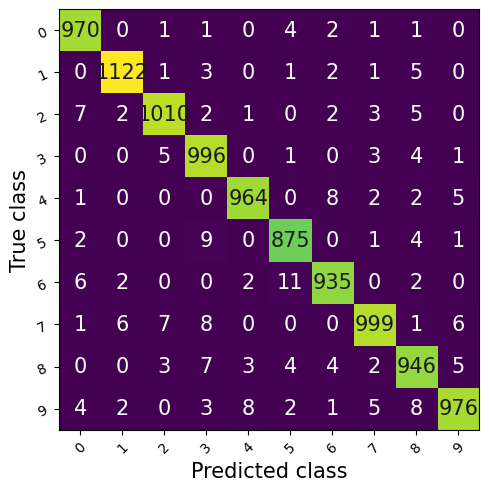

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9774219989776611     │
│         test_loss         │    0.08479885011911392    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
test_acc,▁
test_loss,▁
train_acc,▁▇▇█████████████████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▆▇▇▇▇▇██▇██████████
val_loss,█▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_acc,0.97742
test_loss,0.0848


In [ ]:
trainer.test(model,test_loader,ckpt_path="mlp_lrfinder.ckpt")
wandb.finish()